## Exploring the Met’s Art Collection

The Metropolitan Museum of Art (the Met) dataset presents information about more than 470,000 artworks from its collection. The richness of the dataset allows both uncovering precise details about specific pieces of art and getting an overall picture of the Met's collection. Using information from the dataset, we can answer several interesting questions about artworks exhibited by the Met, including:

1. What types of artwork does the Met has? Which department of the Met boast the most showpieces?
2. What are the most popular artists represented in the Met's collection? What are their nationalities?
3. Which historical periods are represented the most by the Met's exhibits?
4. When were the artworks obtained by the Met?

Where appropriate, I will also compare compare the results for all Met exhibits with the results only for those exhibits that are considered "popular and important".

Let's dive in!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-dark')

pd.set_option('display.max_columns', None)

In [2]:
#reading the full dataset from the project's GitHub
artworks = pd.read_csv('https://github.com/metmuseum/openaccess/blob/master/MetObjects.csv?raw=true', low_memory=False)

#checking the shape of the dataframe
artworks.shape

(477804, 54)

The dataset has 54 columns, but many of them have predominantly missing values or are not particularly interesting to analyze. We will only keep those columns that really matter to our exploration. These will include:

- whether an artwork is considered "popular and important";
- department to which an artwork belongs;
- year when an artwork was acquired;
- type of an artwork;
- title of an artwork;
- name of the artwork author;
- nationality of the artwork author;
- years the artwork author was born and died;
- year when an artwork was finsihed;
- general term decrisibing the artwork type.

Unfortunately, we have to drop the column representing gender of the artists as predominant majority of its values are missing and many other have confusing values.

In [3]:
#keeping only relevant columns
columns_to_keep = [
    'Is Highlight', 'Department', 'AccessionYear', 'Object Name', 'Title', 'Artist Display Name', 
    'Artist Nationality',  'Artist Begin Date', 'Artist End Date', 'Object End Date', 'Classification'
    ]

artworks = artworks[columns_to_keep]

A snapshot of the resulting dataset can be seen below.

In [4]:
artworks.head()

,Is Highlight,Department,AccessionYear,Object Name,Title,Artist Display Name,Artist Nationality,Artist Begin Date,Artist End Date,Object End Date,Classification
0,False,The American Wing,1979,Coin,One-dollar Liberty Head Coin,James Barton Longacre,American,1794,1869,1853,NaN
1,False,The American Wing,1980,Coin,Ten-dollar Liberty Head Coin,Christian Gobrecht,,1785,1844,1901,NaN
2,False,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,NaN,NaN,NaN,NaN,1927,NaN
3,False,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,NaN,NaN,NaN,NaN,1927,NaN
4,False,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,NaN,NaN,NaN,NaN,1927,NaN


Some columns still have missing values. Let's visualize what those are and how many missing values are there in general.

In [5]:
artworks.isna().sum()

Is Highlight                0
Department                  0
AccessionYear            3556
Object Name              1691
Title                   29185
Artist Display Name    202269
Artist Nationality     202269
Artist Begin Date      202269
Artist End Date        202269
Object End Date             0
Classification          78206
dtype: int64

There are quite a lot missing information about the artwork authors. This is undetrstandable given that it is not always possible to establish authors of specific artworks. However, there seems to be no rows with all missing values, so we won't drop any rows.

Let's start with looking at what types of artworks are represented in the Met's collection.

In [6]:
#shortening the title of an object type
artworks['Object Name'] = artworks['Object Name'].replace('Folio from an illustrated manuscript', 'Folio')

#replacing uknwown or anonymous authors with nans
artworks['Artist Display Name'] = artworks['Artist Display Name'].replace(dict.fromkeys(['Unknown', 'Anonymous', 'Unidentified'], np.nan))
artworks[artworks['Artist Display Name'].str.contains('Anonymous,', na=False)] = np.nan

Values in the Artist Nationality columns are quite messy and need cleaning for us to get aggregate statistics about nationalities of authors represented in the Met's collection. I will remove all additional author nationalities and replace some archaic nationalities with their modern equivalents.

In [7]:
artworks['Artist Nationality'] = artworks['Artist Nationality'].str.lstrip(' |')
artworks['Artist Nationality'] = artworks['Artist Nationality'].str.replace(' or', '|')
artworks['Artist Nationality'] = artworks['Artist Nationality'] + '|'

artworks['Artist Nationality'] = artworks['Artist Nationality'].str.extract('(.+?)(?=[\|\,\?\(\/])')
artworks['Artist Nationality'] = artworks['Artist Nationality'].str.strip()
artworks['Artist Nationality'] = artworks['Artist Nationality'].replace({
    'Netherlandish': 'Dutch', 
    'Flemish': 'Dutch',
    'Bohemian': 'Czech'
    })

In [10]:
artworks['Is Highlight'].value_counts()

False    467643
True       2483
Name: Is Highlight, dtype: int64

Only 2,483 artworks (0.5 percent of all exhibits) are considered "popular and important" by the Met.

In [11]:
#creating a separate dataframe containing only "popular and important" artworks
artworks_highlight = artworks[artworks['Is Highlight']==True]

I will create a function to vizualize differences in ditribution of values between all artworks in the collection and highlighted artworks.

In [81]:
def create_subplots(labels, values, labels_highlight, values_highlight, main_title):

    main_font = {'fontsize': 18, 'weight': 'bold'}
    sub_font = {'fontsize': 12, 'weight': 'bold'}

    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(12, 6)
    fig.suptitle(main_title, **main_font)

    axes[0].barh(labels, values, color='royalblue')
    axes[0].tick_params(axis='x', colors='royalblue')
    axes[0].tick_params(axis='y', colors='royalblue')
    axes[1].barh(labels_highlight, values_highlight, color='seagreen')
    axes[1].tick_params(axis='x', colors='seagreen')
    axes[1].tick_params(axis='y', colors='seagreen')

    axes[0].invert_yaxis()
    axes[1].invert_yaxis()

    axes[0].set_title('All artworks', **sub_font, color='royalblue')
    axes[1].set_title('Highlighted artworks', **sub_font, color='seagreen')

    fig.tight_layout()
    plt.show()

Let's start at lookng at the most popular types of artworks represented in the Met's collection.

In [82]:
artwork_types = artworks['Object Name'].value_counts().head(10)
artwork_highlight_types = artworks_highlight['Object Name'].value_counts().head(10)

artwork_types_labels = artwork_types.index
artwork_types_values = artwork_types.values

artwork_highlight_types_labels = artwork_highlight_types.index
artwork_highlight_types_values = artwork_highlight_types.values

artwork_types_title = 'Ten most frequent types of artwork exhibited in the Museum'


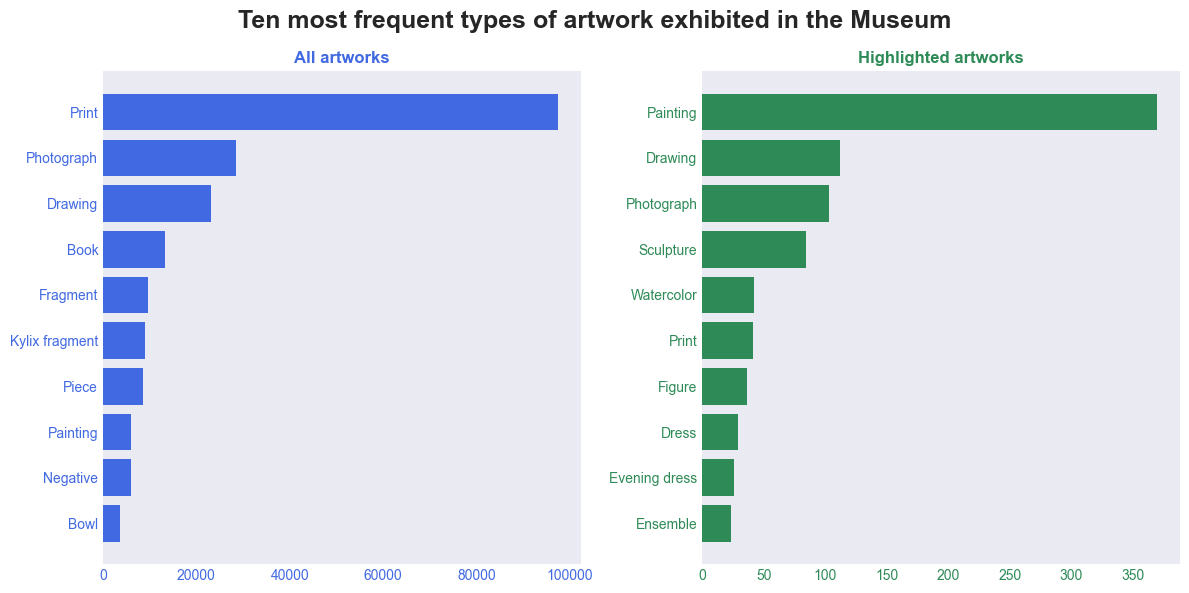

In [83]:
create_subplots(
    artwork_types_labels, artwork_types_values, artwork_highlight_types_labels, 
    artwork_highlight_types_values, artwork_types_title
    )

Print is by far the most popular types of artwork in the overall collection. However, there are much more paintings and drawings among those arteowks that are considered popular and important.

In [84]:
artwork_departments = artworks['Department'].value_counts()
artwork_highlight_departments = artworks_highlight['Department'].value_counts()

artwork_departments_labels = artwork_departments.index
artwork_departments_values = artwork_departments.values

artwork_highlight_departments_labels = artwork_highlight_departments.index
artwork_highlight_departments_values = artwork_highlight_departments.values

artwork_departments_title = 'Number of artworks in different Met departments'


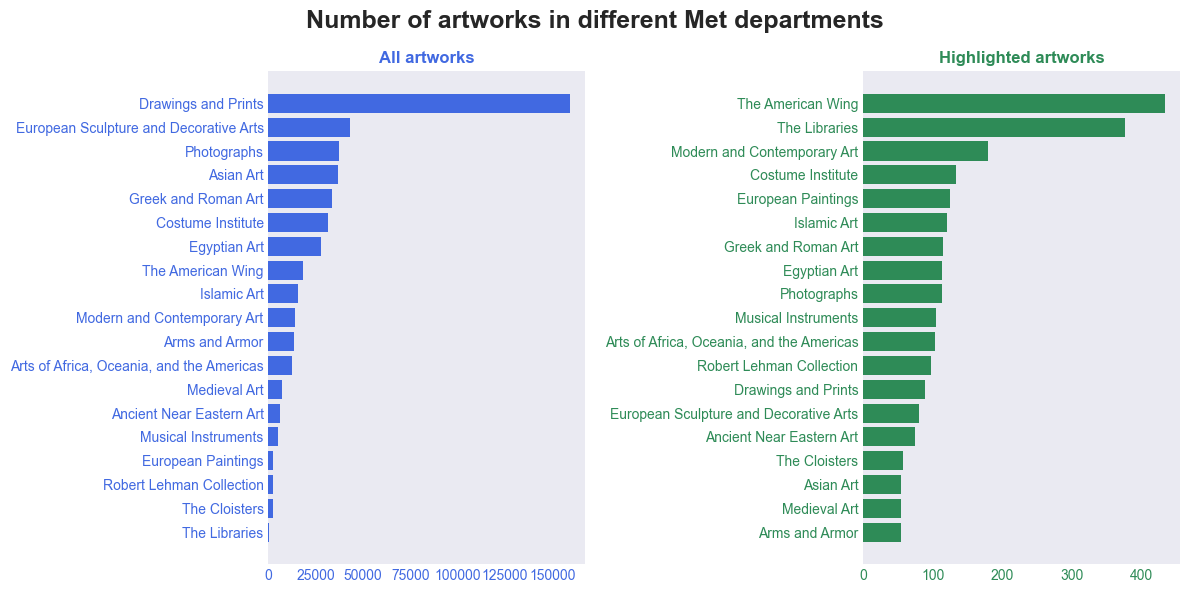

In [85]:
create_subplots(
    artwork_departments_labels, artwork_departments_values, artwork_highlight_departments_labels, 
    artwork_highlight_departments_values, artwork_departments_title
    )

According to the dataset, the Met has 19 departments that store artworks. Drawings and Prints department has the most showpieces overall. However, the American Wing and the Libraries department posses the majority of highlighted artworks.

Let's turn to the authors of the artworks.

In [86]:
artwork_artists = artworks['Artist Display Name'].value_counts().head(10)
artwork_highlight_artists = artworks_highlight['Artist Display Name'].value_counts().head(10)

artwork_artists_labels = artwork_artists.index
artwork_artists_values = artwork_artists.values

artwork_highlight_artists_labels = artwork_highlight_artists.index
artwork_highlight_artists_values = artwork_highlight_artists.values

artwork_artists_title = "Top 10 authors with most artworks in the Met's collection"

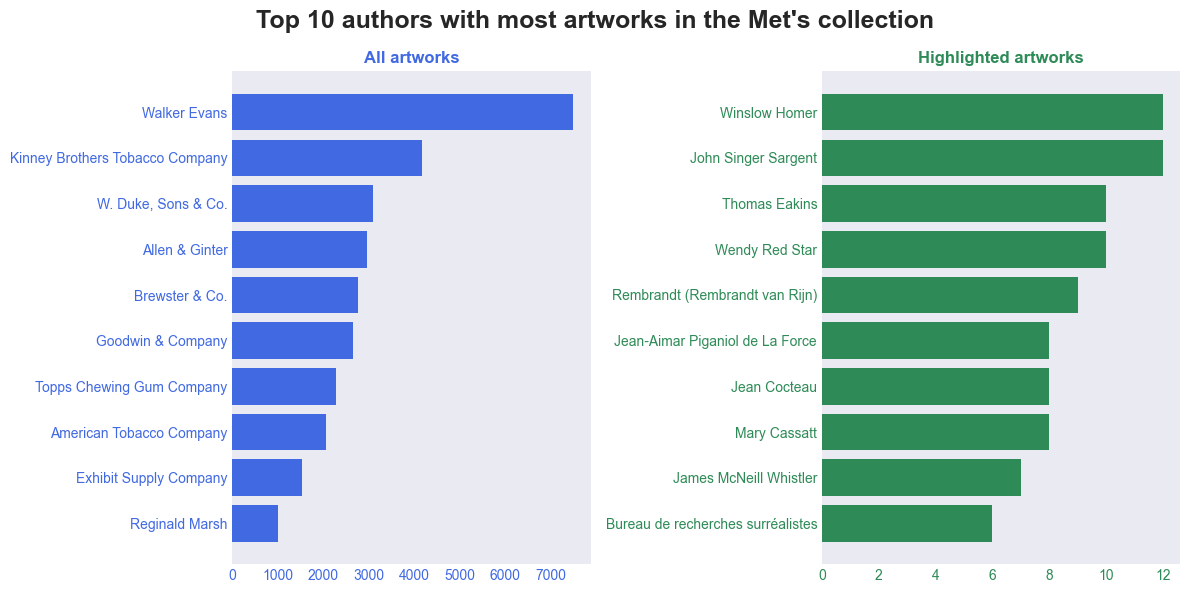

In [87]:
create_subplots(
    artwork_artists_labels, artwork_artists_values, artwork_highlight_artists_labels, 
    artwork_highlight_artists_values, artwork_artists_title
    )

American photographer Walker Evans has the most pieces of art exhibited by the Met. There are also many pieces of art created not by individuals, but by companies, including by tobacco companies. If we look at the highlighted pieces of art, the list of top artists by the number of artworks include many American painters, as well as some other classic artists.

In [88]:
artwork_nationalities = artworks['Artist Nationality'].value_counts().head(10)
artwork_highlight_nationalities = artworks_highlight['Artist Nationality'].value_counts().head(10)

artwork_nationalities_labels = artwork_nationalities.index
artwork_nationalities_values = artwork_nationalities.values

artwork_highlight_nationalities_labels = artwork_highlight_nationalities.index
artwork_highlight_nationalities_values = artwork_highlight_nationalities.values

artwork_nationalities_title = "Top 10 nationalities of artists in the Met's collection"

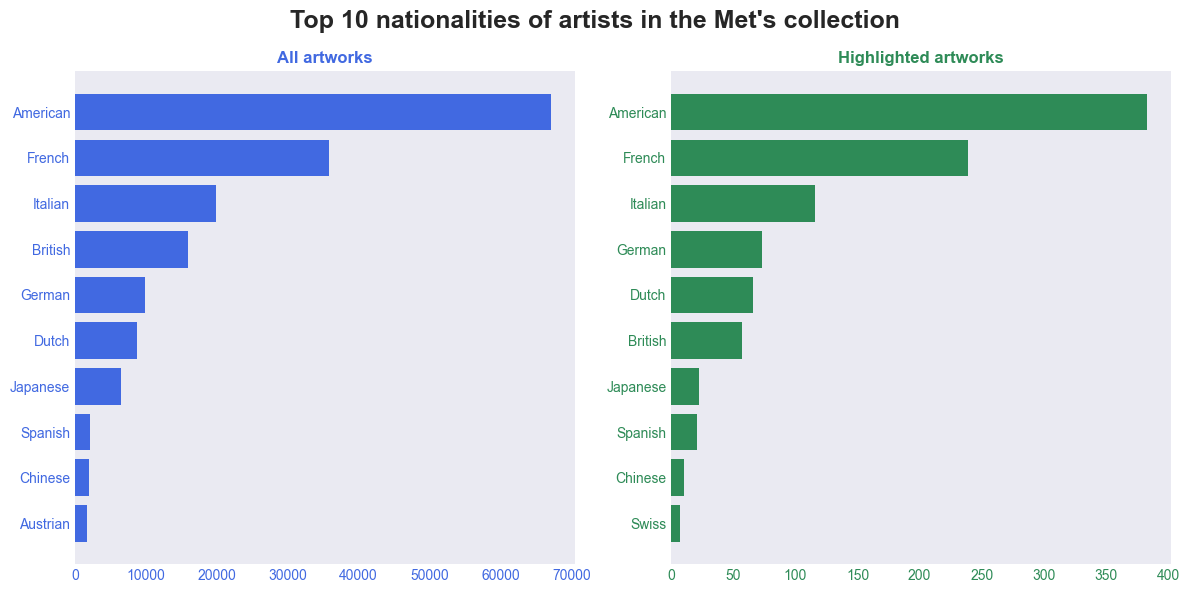

In [89]:
create_subplots(
    artwork_nationalities_labels, artwork_nationalities_values, artwork_highlight_nationalities_labels, 
    artwork_highlight_nationalities_values, artwork_nationalities_title
    )

American authors dominate the Museum's collection, both in general and if we limit ourselves to the highlighted artworks. French, Italian, German, British, and Dutch authors are also well represented.

It is alo interesting to look at the historical periods when the artworks exhibited by the Museum were created.

In [90]:
#function for getting centuries out of years
def get_century(year):
    century = (year - 1) // 100 + 1
    if year > 0:
        return century
    elif year < 0:
        return century - 1
    else:
        return np.nan

In [91]:
#adding column represeting century when an artworks was completed
artworks['Object End Century'] = artworks['Object End Date'].apply(get_century)

#adding column represeting decade when an artworks was completed
artworks['Object End Decade'] = artworks['Object End Date'] // 10 * 10

#getting the earliest and latest centuries
min_century = artworks['Object End Century'].min()
print(f"The earliest artwork from the Museum's collection was created in the {int(min_century * -1)}st century BC")

The earliest artwork from the Museum's collection was created in the 2401st century BC


The artworks owned by the Museum span from 3rd millenia BC to the present (with some erroneos entries). The majority of them were created in 19th and 20th century. Let's look at the ditribution of the decades when these pieces of art were created.

In [92]:
#getting only artworks created since the 19th century
artworks_decades = artworks['Object End Decade']
artworks_19_21_centuries = artworks_decades[(artworks_decades >= 1800) & (artworks_decades <= 2020)]

In [93]:
#function for creating a dictibution of artworks by decades
def create_histogram(values, labels, bins, title):

    fig = plt.figure()

    fig.set_size_inches(9, 6)
    main_font = {'fontsize': 18, 'weight': 'bold'}

    plt.hist(values, bins=bins, color='royalblue', edgecolor='darkblue')

    plt.title(title, **main_font)
    plt.xticks(labels, rotation=60)

    plt.show() 

In [94]:
decade_values = artworks_decades[(artworks_decades >= 1800) & (artworks_decades <= 2020)]
decade_labels = artworks_19_21_centuries.value_counts().index
decabe_bins = 23
decade_title = 'Number of artworks created in different decades (since 1800)'

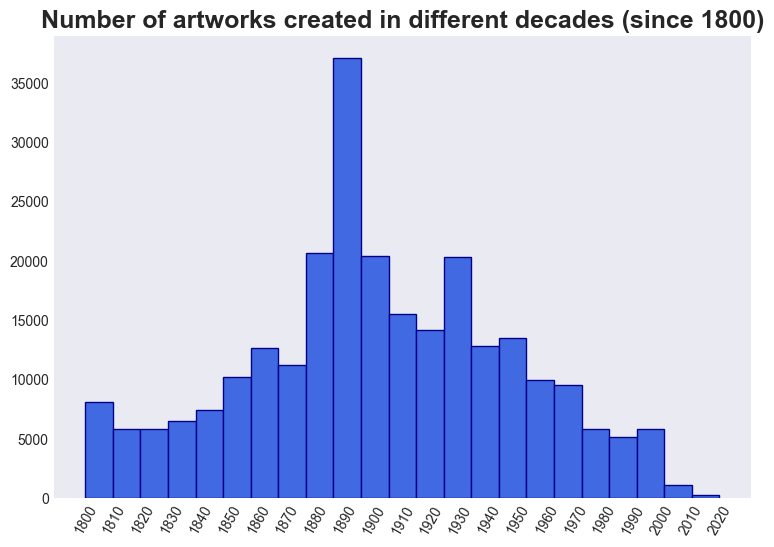

In [95]:
create_histogram(decade_values, decade_labels, decabe_bins, decade_title)

Most of the artworks were created in late 1800s and early 1900s, with the decade of 1890s being represented the most.

In [96]:
#removing noise from the AssecionYear column
artworks['AccessionYear'] = artworks['AccessionYear'].str.slice(stop=4).astype('float')

#getting the acquisition decade
artworks['Accession Decade'] = artworks['AccessionYear'] // 10 * 10

In [100]:
decade_acquisition_values = artworks['Accession Decade']
decade_acquisition_labels = artworks['Accession Decade'].value_counts().index
decade_acquisition_title = 'Number of artworks acquired by the Met in different decades'
decade_acquisition_bins = 16

Let's look at when the artworks were acquired by the Met.

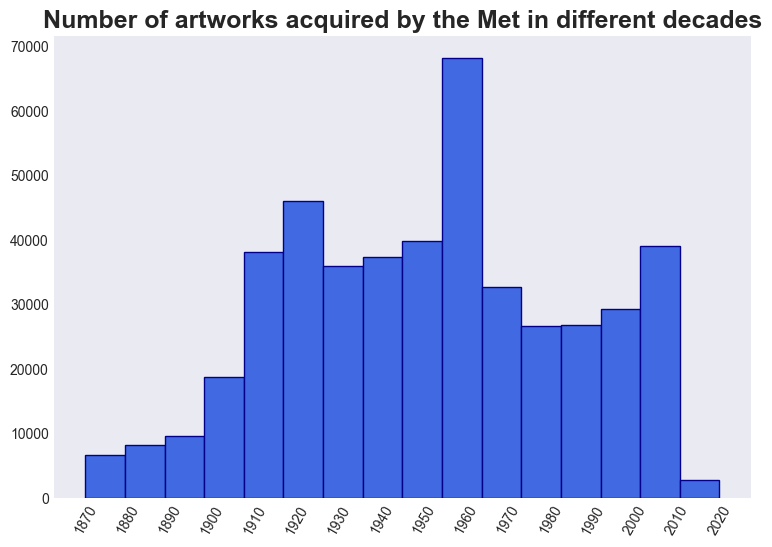

In [101]:
create_histogram(decade_acquisition_values, decade_acquisition_labels, decade_acquisition_bins, decade_acquisition_title)

The Met has been acquiring its pieces of art relatively unifomily over the decades since the beginning of the 20th century. The one significant spike was in the 1960s when the Museum get significantly more artworks than in other decades.

As further steps, it might be interesting to explore the dataset further by deepdiving into the data about specific types of artworks/artists/periods, comparing various segment of the dataset, or investigating the highlighted artworks in more details. 